# Dogs vs. cats image classification: Inception V3

In [1]:
# Handle imports up-front
import os
import sys
import glob
import pickle
from pathlib import Path

# Silence logging messages from TensorFlow, except errors
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

# Use a specific GPU, if desired
# os.environ['CUDA_VISIBLE_DEVICES']='0'

# PyPI imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import SGD
from keras import regularizers
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Figure out if we are running on Kaggle or not, if so
# add the location of utils.py to path so we can import
path_list=os.getcwd().split(os.sep)

if path_list[1] == 'kaggle':
    sys.path.append('/kaggle/usr/lib/image_classification_functions')

# Import custom helper functions from utils.py
from image_classification_functions import prep_data
from image_classification_functions import plot_single_training_run

# Silence logging messages from TensorFlow, except errors
tf.get_logger().setLevel('ERROR')

# Limit TensorFlow's CPU usage
tf.config.threading.set_intra_op_parallelism_threads(2)
tf.config.threading.set_inter_op_parallelism_threads(2)

In [2]:
tune_output=False
tune_inception_block=True

model_path='/kaggle/working/models'
Path(model_path).mkdir(parents=True, exist_ok=True)
output_tuned_savefile=f'{model_path}/inceptionV3_output_tuned.pkl'
inception_tuned_savefile=f'{model_path}/inceptionV3_tuned.pkl'

## 1. Data preparation

### 1.1. Load the data paths

In [3]:
# Decompress and organize the images
training_data_path, validation_data_path, testing_data_path=prep_data()

# Get lists of training and validation dog and cat images
training_dogs=glob.glob(f'{training_data_path}/dogs/dog.*')
training_cats=glob.glob(f'{training_data_path}/cats/cat.*')
validation_dogs=glob.glob(f'{validation_data_path}/dogs/dog.*')
validation_cats=glob.glob(f'{validation_data_path}/cats/cat.*')

Running in Kaggle notebook
Checking data prep
Data prep already complete


### 1.2. Create training and validation datasets

In [4]:
training_dataset=tf.keras.utils.image_dataset_from_directory(
    training_data_path,
    image_size=(256, int(256*(3/4))),
    batch_size=256
)

validation_dataset=tf.keras.utils.image_dataset_from_directory(
    validation_data_path,
    image_size=(256, int(256*(3/4))),
    batch_size=256
)

Found 15000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


### 1.3. Create testing dataset

In [5]:
testing_dataset=tf.keras.utils.image_dataset_from_directory(
    training_data_path,
    image_size=(256, int(256*(3/4)))
)

Found 15000 files belonging to 2 classes.


## 2. Model fine-tuning
### 2.1. Train output layers

In [6]:
%%time

l1_penalty=1e-4
l2_penalty=1e-3

if tune_output == True:

    # create the base pre-trained model
    base_model=InceptionV3(weights='imagenet', include_top=False)

    # Add some output layers
    x=base_model.output
    x=GlobalAveragePooling2D()(x)
    x=Dropout(0.5)(x)
    x=Dense(
        1024,
        activation='relu',
        kernel_regularizer=regularizers.L1L2(l1=l1_penalty, l2=1e-3)
    )(x)
    x=Dense(
        256,
        activation='relu',
        kernel_regularizer=regularizers.L1L2(l1=l1_penalty, l2=1e-3)
    )(x)
    x=Dense(
        128,
        activation='relu',
        kernel_regularizer=regularizers.L1L2(l1=l1_penalty, l2=1e-3)
    )(x)
    x=Dense(
        64,
        activation='relu',
        kernel_regularizer=regularizers.L1L2(l1=l1_penalty, l2=1e-3)
    )(x)
    predictions=Dense(1, activation='sigmoid')(x)

    model=Model(inputs=base_model.input, outputs=predictions)

    # Train only the output layers by freezing all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model to train on binary cross-entropy loss
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['binary_accuracy'])

    # Train the model on the new data for a few epochs
    training_result=model.fit(
        training_dataset,
        validation_data=validation_dataset,
        epochs=20
    )

    # Save the results
    with open(output_tuned_savefile, 'wb') as output_file:
        pickle.dump(training_result, output_file, protocol=pickle.HIGHEST_PROTOCOL)

else:
    with open(output_tuned_savefile, 'rb') as output_file:
        training_result=pickle.load(output_file)

print()

Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 69s 755ms/step - binary_accuracy: 0.5138 - loss: 30.4273 - val_binary_accuracy: 0.5000 - val_loss: 9.2738
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 17s 282ms/step - binary_accuracy: 0.5092 - loss: 6.2550 - val_binary_accuracy: 0.5000 - val_loss: 3.6094
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 17s 283ms/step - binary_accuracy: 0.5376 - loss: 3.2269 - val_binary_accuracy: 0.5836 - val_loss: 1.8955
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 17s 283ms/step - binary_accuracy: 0.5351 - loss: 1.8280 - val_binary_accuracy: 0.5518 - val_loss: 1.2932
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 17s 283ms/step - binary_accuracy: 0.5684 - loss: 1.2445 - val_binary_accuracy: 0.6132 - val_loss: 1.0186
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 17s 283ms/step - binary_accuracy: 0.5738 - loss: 1.0231 - val_binary_accuracy: 0.6128 - val_loss: 0.9012
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 17s 284ms/step - binary_accuracy: 0.5972 - loss: 0.8929 - val_binary_accuracy: 0.6248 - val_loss: 0.828

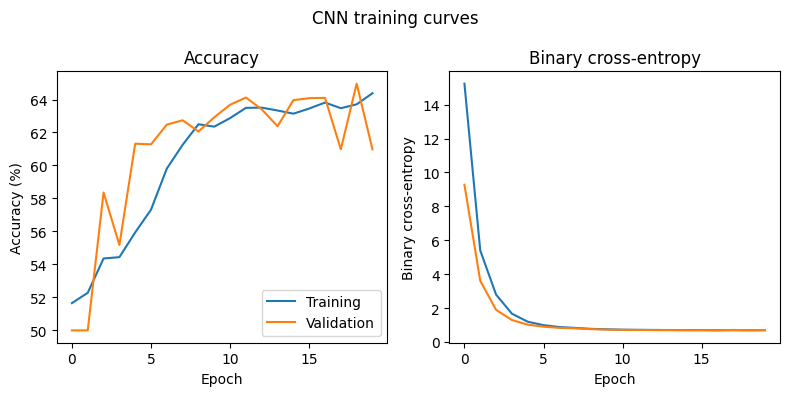

In [7]:
# Plot the results
plot_single_training_run(training_result).show()

### 2.2. Train inception layers

In [8]:
# Take a look at the model and decide how many layers to freeze and how many to train
training_result.model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None, None, 3)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, None, None, 32) │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, None, None, 32) │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, None, None, 32) │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, None, None, 32) │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, None, None, 32) │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, None, None, 32) │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, None, None, 64) │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, None, None, 64) │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, None, None, 64) │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, None, None, 64) │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, None, None, 80) │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, None, None, 80) │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, None, None, 80) │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, None, None,     │        138,240 │ activation_3[0][0]     │
│                           │ 192)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, None, None,     │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │ 192)                   │                │                        │
├──────────────────────

 Total params: 26,606,372 (101.50 MB)

 Trainable params: 2,401,793 (9.16 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

 Optimizer params: 2,401,795 (9.16 MB)

In [ ]:
%%time

if tune_inception_block is True:

    # Train the top 2 inception blocks, by freezing the first 249 layers
    # and leaving the rest unfrozen
    for layer in model.layers[:249]:
        layer.trainable = False
    for layer in model.layers[249:]:
        layer.trainable = True

    # Recompile the model using SGD with a low learning rate
    model.compile(
        optimizer=SGD(learning_rate=0.0001, momentum=0.9),
        loss='binary_crossentropy',
        metrics=['binary_accuracy']
    )

    # Train again
    training_result=model.fit(
        training_dataset,
        validation_data=validation_dataset,
        epochs=100
    )

    # Save the results
    with open(inception_tuned_savefile, 'wb') as output_file:
        pickle.dump(training_result, output_file, protocol=pickle.HIGHEST_PROTOCOL)

else:
    with open(inception_tuned_savefile, 'rb') as output_file:
        training_result=pickle.load(output_file)

print()

Epoch 1/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 55s 592ms/step - binary_accuracy: 0.4998 - loss: 0.7465 - val_binary_accuracy: 0.5000 - val_loss: 0.7431
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 19s 320ms/step - binary_accuracy: 0.4981 - loss: 0.7452 - val_binary_accuracy: 0.5000 - val_loss: 0.7429
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 19s 321ms/step - binary_accuracy: 0.4986 - loss: 0.7437 - val_binary_accuracy: 0.5000 - val_loss: 0.7418
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 19s 319ms/step - binary_accuracy: 0.4976 - loss: 0.7422 - val_binary_accuracy: 0.5000 - val_loss: 0.7405
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 19s 319ms/step - binary_accuracy: 0.5011 - loss: 0.7402 - val_binary_accuracy: 0.5000 - val_loss: 0.7391
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 19s 319ms/step - binary_accuracy: 0.4966 - loss: 0.7392 - val_binary_accuracy: 0.5000 - val_loss: 0.7376
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 19s 320ms/step - binary_accuracy: 0.4975 - loss: 0.7376 - val_binary_accuracy: 0.5000 - val_loss:

In [ ]:
# Plot the results
plot_single_training_run(training_result).show()

## 3. Model evaluation

### 3.2. Make predictions

In [ ]:
images=np.concatenate([x for x, y in validation_dataset], axis=0)
labels=np.concatenate([y for x, y in validation_dataset], axis=0)

predictions=training_result.model.predict(images)
print(f'Testing images shape: {images.shape}')
print(f'Testing labels shape: {labels.shape}')

threshold=0.5
predictions=[1 if p > threshold else 0 for p in predictions]

accuracy=accuracy_score(predictions, labels)*100
print(f'Test set accuracy: {accuracy:.1f}%')

### 3.3. Model performance

In [ ]:
# Plot the confusion matrix
cm=confusion_matrix(labels, predictions, normalize='true')
cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm)
_=cm_disp.plot()

plt.title(f'Test set performance\noverall accuracy: {accuracy:.1f}%')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.show()